In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests
import nasdaqdatalink
import os
NIALL_KEY = 'gtxAZhfYsUfxJ9TUa5jW'
nasdaqdatalink.ApiConfig.api_key = NIALL_KEY

# Load in Asset Data

In [8]:

# Define the asset universe
tickers = {
    # US Equities
    'SPY': 'QUOTEMEDIA/PRICES',  # S&P 500 ETF
    'QQQ': 'QUOTEMEDIA/PRICES',  # Nasdaq 100 ETF
    'IWM': 'QUOTEMEDIA/PRICES',  # Russell 2000 ETF (Small Cap)
    # International Equities
    'EFA': 'QUOTEMEDIA/PRICES',  # MSCI EAFE ETF (Developed Markets ex-US/Canada)
    'EEM': 'QUOTEMEDIA/PRICES',  # MSCI Emerging Markets ETF
    # Fixed Income
    'AGG': 'QUOTEMEDIA/PRICES',  # US Aggregate Bond ETF
    'TLT': 'QUOTEMEDIA/PRICES',  # US 20+ Year Treasury Bond ETF
    # Commodities
    'GLD': 'QUOTEMEDIA/PRICES',  # Gold ETF
    'USO': 'QUOTEMEDIA/PRICES',  # Oil ETF
    # Real Estate
    'VNQ': 'QUOTEMEDIA/PRICES',   # US Real Estate ETF
    # Adding a couple more for diversity
    'GSG': 'QUOTEMEDIA/PRICES', # Broad Commodities ETF
    'HYG': 'QUOTEMEDIA/PRICES'  # High Yield Corporate Bond ETF
}

start_date = '2010-01-01'


In [9]:
# Fetch data for each ticker
all_data = {}
for ticker, table in tickers.items():
    try:
        # Fetch data from the specified start_date
        data = nasdaqdatalink.get_table(
            table, 
            ticker=ticker, 
            qopts={'columns': ['date', 'adj_close']},
            date={'gte': start_date},
            paginate=True
        )
        if not data.empty:
            data = data.set_index('date')
            all_data[ticker] = data['adj_close']
        else:
            print(f"No data found for {ticker}")
    except Exception as e:
        print(f"Could not retrieve data for {ticker}: {e}")

# Combine into a single DataFrame
if all_data:
    price_df = pd.DataFrame(all_data)
    price_df = price_df.sort_index() # Ensure dates are in ascending order
    print("\nSuccessfully fetched and combined data for all available tickers.")
    print(f"Price data from {price_df.index.min()} to {price_df.index.max()}")
else:
    print("No data was fetched. Please check ticker symbols and API key.")


Successfully fetched and combined data for all available tickers.
Price data from 2010-01-04 00:00:00 to 2025-05-13 00:00:00


In [11]:
# Resample to monthly frequency (end of month) and calculate returns
if 'price_df' in locals() and not price_df.empty:
    # Forward fill to handle missing values before resampling, then backfill
    price_df_filled = price_df.ffill().bfill()
    
    # Resample to monthly frequency, taking the last available price in the month
    monthly_prices = price_df_filled.resample('M').last()
    
    # Calculate monthly returns
    monthly_returns = monthly_prices.pct_change()
    
    # Drop the first row of NaNs resulting from pct_change()
    monthly_returns = monthly_returns.dropna(how='all', axis=0)

else:
    print("price_df is not available or empty. Cannot calculate monthly returns.")

In [12]:
# Standardize the monthly returns by their volatility
if 'monthly_returns' in locals() and not monthly_returns.empty:
    # Calculate the standard deviation for each asset's monthly returns
    returns_std = monthly_returns.std()
    
    # Standardize the returns
    # Avoid dividing by zero if any asset has zero standard deviation (e.g., if all returns are the same or NaN)
    standardized_monthly_returns = monthly_returns.copy()
    for col in standardized_monthly_returns.columns:
        if returns_std[col] != 0:
            standardized_monthly_returns[col] = standardized_monthly_returns[col] / returns_std[col]
        else:
            print(f"Warning: Standard deviation for {col} is 0. Standardized returns for this asset will be set to 0 or NaN depending on original values.")
            if monthly_returns[col].notna().all() and (monthly_returns[col] == 0).all():
                 standardized_monthly_returns[col] = 0 # All returns were 0
            else:
                 standardized_monthly_returns[col] = np.nan # Or handle as appropriate for other zero std cases
else:
    print("monthly_returns DataFrame is not available or empty. Cannot standardize returns.")

<Axes: xlabel='date'>

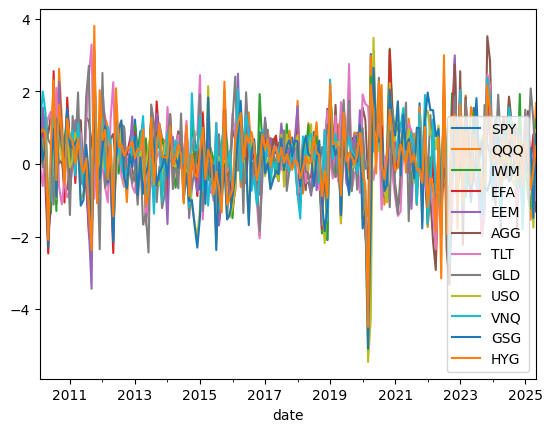

In [13]:
standardized_monthly_returns.plot()

# Load in Macro Data

In [15]:
FILE1             = "../data/Assignment_2_data.xlsm"

fed = pd.read_excel(FILE1, sheet_name='FF', index_col='Date')
fed.rename(columns={'Rate': 'PX_Last'}, inplace=True)
fed = fed[~fed.index.duplicated(keep='last')]

fed = (fed            # daily EFFR
           .resample('M').mean()      # calendar‑month mean
           .asfreq('B', method='ffill')  # fill forward to biz days
           [fed.index.min():])   # trim to asset window
# select only >2010
fed = fed[fed.index >= '2010-01-01']

<Axes: xlabel='Date'>

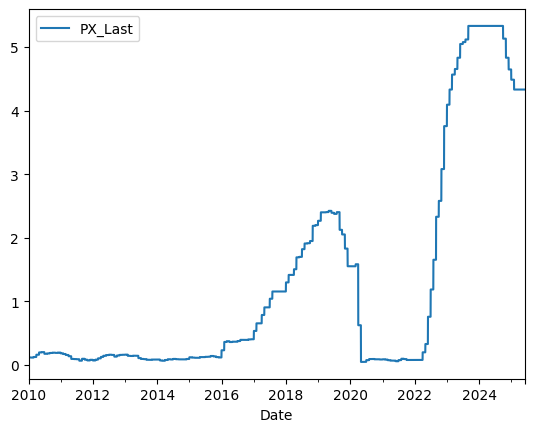

In [16]:
fed.plot()

In [17]:
ism = pd.read_excel(FILE1, sheet_name='ISM', index_col='Date')
ism = ism[~ism.index.duplicated(keep='last')]
ism = ism[ism.index >= '2010-01-01']
ism


,ISM
Date,
2010-01-31,56.3
2010-02-28,55.5
2010-03-31,58.8
2010-04-30,58.1
2010-05-31,57.4
...,...
2024-12-31,49.2
2025-01-31,50.9
2025-02-28,50.3


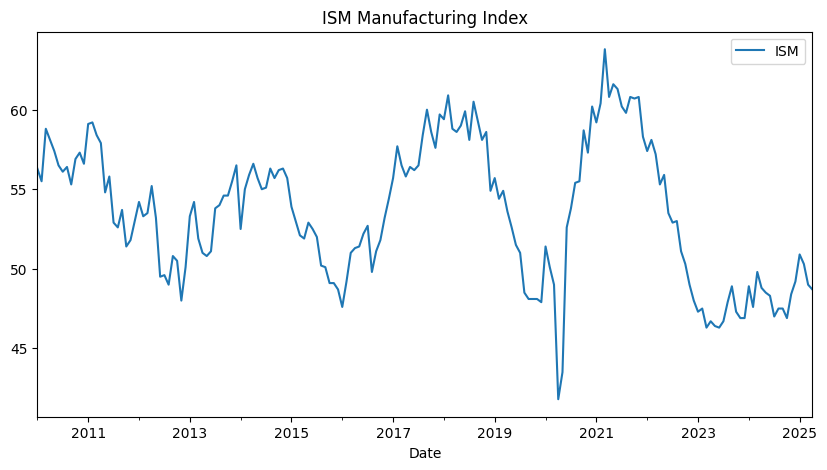

In [18]:
ism.plot(figsize = (10, 5))
plt.title("ISM Manufacturing Index")
plt.show()

In [19]:
nfp = pd.read_csv("../data/nonfarm_payrolls.csv", index_col = "observation_date")
nfp.index = pd.to_datetime(nfp.index)
nfp.rename(columns = {"PAYEMS": "nfp"}, inplace = True)
nfp.index.name = "Date"
nfp

,nfp
Date,
2010-01-01,129802
2010-02-01,129705
2010-03-01,129865
2010-04-01,130120
2010-05-01,130643
...,...
2024-12-01,158942
2025-01-01,159053
2025-02-01,159155


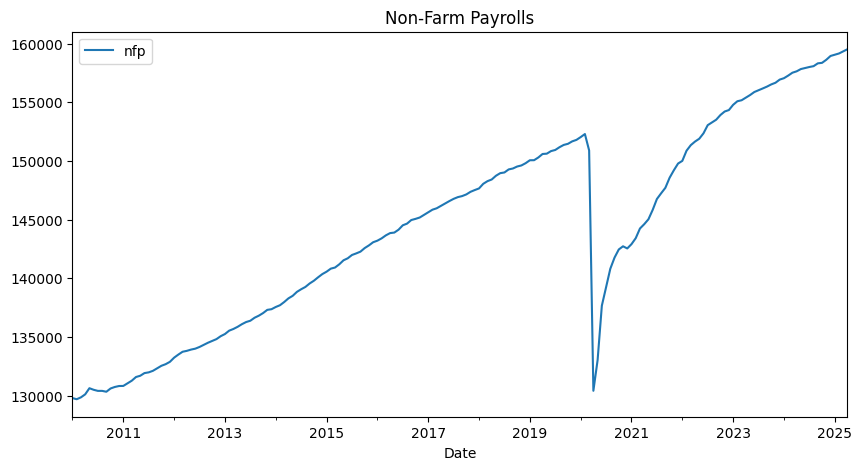

In [20]:
nfp.plot(figsize = (10, 5))
plt.title("Non-Farm Payrolls")
plt.show()

In [21]:
pce = pd.read_csv("../data/core_pce.csv", index_col = "observation_date")
pce.index = pd.to_datetime(pce.index)
pce.rename(columns = {"PCEPILFE": "pce"}, inplace = True)
pce.index.name = "Date"
pce

,pce
Date,
2008-11-01,87.952
2008-12-01,87.909
2009-01-01,87.882
2009-02-01,87.952
2009-03-01,88.015
...,...
2024-11-01,123.716
2024-12-01,123.980
2025-01-01,124.398


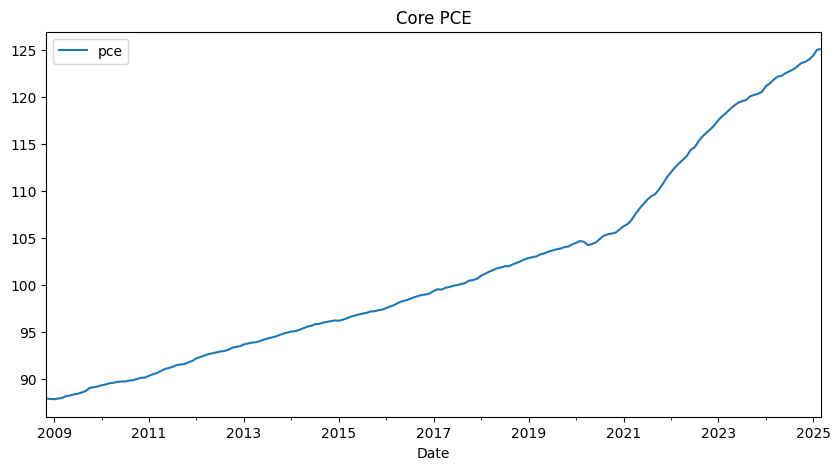

In [22]:
pce.plot(figsize = (10, 5))
plt.title("Core PCE")
plt.show()

# PC price factors

In [62]:
from sklearn.decomposition import PCA
from scipy import stats
import statsmodels.api as sm

In [46]:
def get_daily_standardized_returns(price_df):
    """
    Convert price dataframe to daily standardized returns.
    
    Parameters:
    price_df (pd.DataFrame): DataFrame containing price data for multiple assets
    
    Returns:
    pd.DataFrame: DataFrame containing standardized daily returns
    """
    if not isinstance(price_df, pd.DataFrame) or price_df.empty:
        print("price_df is not available or empty. Cannot calculate daily returns.")
        return None
        
    # Forward fill to handle missing values before calculating returns, then backfill
    price_df_filled = price_df.ffill().bfill()
    
    # Calculate daily returns (no need to resample since data is already daily)
    daily_returns = price_df_filled.pct_change()
    
    # Drop the first row of NaNs resulting from pct_change()
    daily_returns = daily_returns.dropna(how='all', axis=0)
    
    # Calculate the standard deviation for each asset's daily returns
    returns_std = daily_returns.std()
    
    # Standardize the returns
    standardized_daily_returns = daily_returns.copy()
    
    for col in standardized_daily_returns.columns:
        if returns_std[col] != 0:
            standardized_daily_returns[col] = standardized_daily_returns[col] / returns_std[col]
        else:
            print(f"Warning: Standard deviation for {col} is 0. Standardized returns for this asset will be set to 0 or NaN depending on original values.")
            
            if daily_returns[col].notna().all() and (daily_returns[col] == 0).all():
                standardized_daily_returns[col] = 0  # All returns were 0
            else:
                standardized_daily_returns[col] = np.nan  # Handle zero std cases
    
    return standardized_daily_returns

In [47]:
standardized_daily_returns = get_daily_standardized_returns(price_df)

In [48]:
standardized_daily_returns.head()

,SPY,QQQ,IWM,EFA,EEM,AGG,TLT,GLD,USO,VNQ,GSG,HYG
date,,,,,,,,,,,,
2010-01-05,0.241291,0.000000,-0.243270,0.075209,0.533950,1.514744,0.672551,-0.092475,0.155563,-0.085709,0.759150,0.887500
2010-01-06,0.064177,-0.459023,-0.066575,0.360686,0.153901,-0.192496,-1.394077,1.675332,0.620095,-0.137288,0.546593,0.483717
2010-01-07,0.384784,0.049479,0.521998,-0.329237,-0.426610,-0.385214,0.175164,-0.628296,-0.273044,0.825213,-0.361767,0.755170
2010-01-08,0.303336,0.626333,0.385875,0.676048,0.583574,0.192830,-0.046632,0.503934,0.230765,-0.561269,0.159038,0.292496
2010-01-11,0.127300,-0.310610,-0.285095,0.700544,-0.153260,-0.256958,-0.571498,1.349343,-0.426365,0.445486,-0.362748,-0.166880


## 10

For now, we will use some dummy data for the **estimation sample data**

In [49]:
estimation_end = '2024-12-31'

In [50]:
estimation_data = standardized_monthly_returns[standardized_monthly_returns.index <= estimation_end]

In [51]:
pca = PCA()
pc_scores = pca.fit_transform(estimation_data)

Create a DF with the PC scores below (to be used later)

In [52]:
pc_df = pd.DataFrame(
    pc_scores, 
    index=estimation_data_clean.index, 
    columns=[f'PC{i+1}' for i in range(len(estimation_data.columns))]
)

In [53]:
pc_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
date,,,,,,,,,,,,
2010-02-28,-1.674234,-0.427952,0.687867,-0.222406,-0.814089,0.015026,-0.067855,0.066188,0.485611,-0.106137,-0.016642,0.102646
2010-03-31,-3.223089,-0.275293,-1.050174,0.425704,-0.070577,-0.701000,-0.606387,0.327563,0.234714,-0.148095,-0.338360,0.105746
2010-04-30,-1.048585,1.041759,1.039980,-0.334928,-1.412498,-0.294152,-0.020681,-0.401041,0.621705,0.029354,0.079722,0.161593
2010-05-31,5.559990,2.289960,0.389356,0.210922,-0.540866,-0.006306,-0.403487,-0.588207,0.088033,-0.473899,-0.289373,-0.122640
2010-06-30,2.049625,1.293427,1.924890,-0.960505,1.111987,-0.180366,0.824318,-0.134162,-0.064930,0.139269,0.110851,0.068139
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.607678,1.377303,0.132984,-0.065114,0.159372,-0.468632,0.203969,0.726269,-0.261076,-0.195171,0.020627,-0.216659
2024-09-30,-0.940400,1.311696,0.623010,0.684739,0.302047,-0.294867,0.088007,-0.005611,0.487277,-0.191759,0.246767,-0.121021
2024-10-31,1.731832,-2.216786,0.636582,1.130351,-1.020752,0.097115,0.124752,0.017121,0.499501,0.277833,-0.308049,-0.048976


## 11

In [54]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=estimation_data_clean.columns,
    columns=[f'PC{i+1}' for i in range(len(estimation_data_clean.columns))]
)

In [55]:
explained_variance = pca.explained_variance_ratio_ * 100

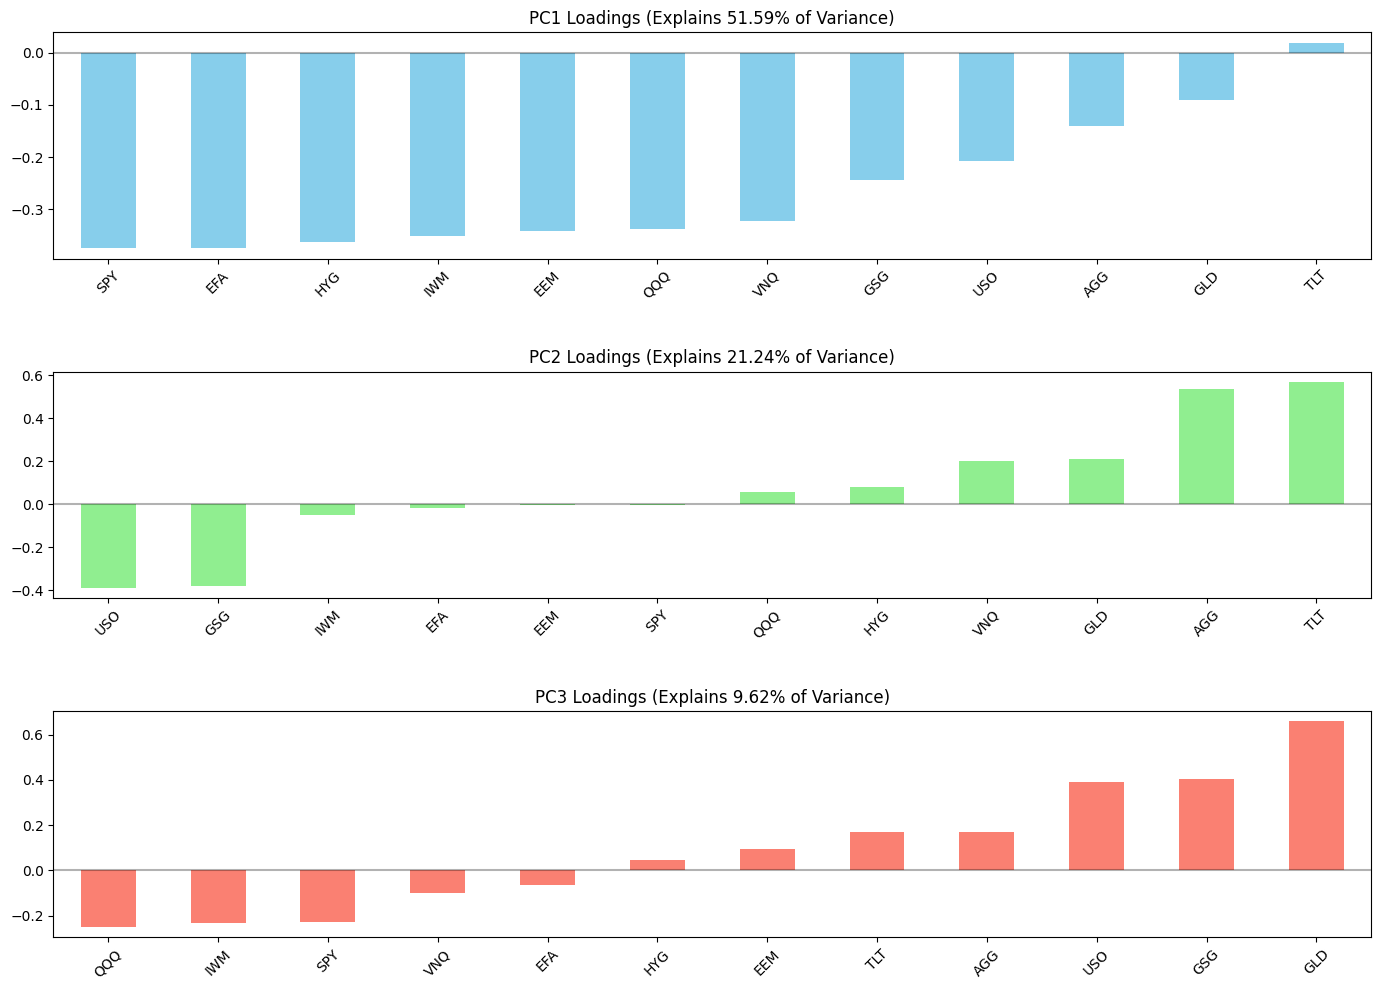

In [56]:
plt.figure(figsize=(14, 10))

# PC1 loadings
plt.subplot(3, 1, 1)
loadings['PC1'].sort_values().plot(kind='bar', color='skyblue')
plt.title(f'PC1 Loadings (Explains {explained_variance[0]:.2f}% of Variance)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# PC2 loadings
plt.subplot(3, 1, 2)
loadings['PC2'].sort_values().plot(kind='bar', color='lightgreen')
plt.title(f'PC2 Loadings (Explains {explained_variance[1]:.2f}% of Variance)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# PC3 loadings
plt.subplot(3, 1, 3)
loadings['PC3'].sort_values().plot(kind='bar', color='salmon')
plt.title(f'PC3 Loadings (Explains {explained_variance[2]:.2f}% of Variance)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()

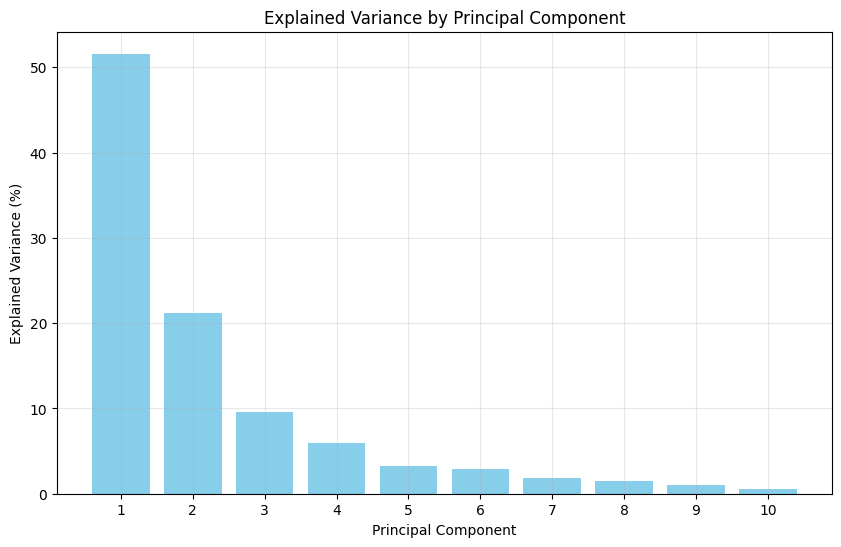

In [57]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, min(10, len(explained_variance))+1), explained_variance[:10], color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by Principal Component')
plt.xticks(range(1, min(10, len(explained_variance))+1))
plt.grid(True, alpha=0.3)
plt.show()

## 12

In [85]:
estimation_end = '2024-12-31'
oos_start = '2025-01-01'

In [86]:
in_sample_data = standardized_monthly_returns[standardized_monthly_returns.index <= estimation_end]
out_sample_data = standardized_monthly_returns[standardized_monthly_returns.index >= oos_start]

In [87]:
pca = PCA()
pc_scores_in = pca.fit_transform(in_sample_data)

In [88]:
pc_df_in = pd.DataFrame(
    pc_scores_in, 
    index=in_sample_data.index, 
    columns=[f'PC{i+1}' for i in range(len(in_sample_data.columns))]
)

In [90]:
pc_scores_out = pca.transform(out_sample_data)
pc_df_out = pd.DataFrame(
    pc_scores_out,
    index=out_sample_data.index,
    columns=[f'PC{i+1}' for i in range(len(out_sample_data.columns))]
)

In [91]:
pc_df_out

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
date,,,,,,,,,,,,
2025-01-31,-1.300696,0.152377,1.124949,0.624275,-0.098178,0.037059,0.091179,0.079440,-0.620728,0.089979,0.054062,0.018741
2025-02-28,0.393334,1.814619,0.910988,-0.638802,0.758357,-0.709539,-0.149329,0.676545,-0.422002,-0.050650,0.175465,-0.013447
2025-03-31,2.033694,-0.616013,2.679521,1.080245,0.463490,-0.875944,-0.183458,0.227617,-0.557942,-0.145548,-0.019373,0.149443
2025-04-30,1.121978,1.004977,-0.411298,2.116611,0.476420,-0.143744,0.394866,0.343558,-0.807905,-0.212770,-0.156223,0.296713
2025-05-31,-1.917205,-2.131847,-0.759010,0.506022,-0.072097,0.705982,-0.299017,-0.276254,0.542411,0.415962,-0.141862,0.034149


In [102]:
regression_results = {}
predictions = {}
residuals = {}
r_squared = {}
betas_to_pc1 = {}

In [103]:
for asset in in_sample_data.columns:
    # Prepare the data for full model (PC1, PC2, PC3)
    y = in_sample_data[asset]
    X = sm.add_constant(pc_df_in[['PC1', 'PC2', 'PC3']])
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    regression_results[asset] = model
    r_squared[asset] = model.rsquared
    
    # Calculate beta to PC1 specifically
    X_pc1 = sm.add_constant(pc_df_in['PC1'])
    model_pc1 = sm.OLS(y, X_pc1).fit()
    betas_to_pc1[asset] = model_pc1.params[1]  # Skip the constant term
    
    # Predict out-of-sample returns using the fitted model
    X_oos = sm.add_constant(pc_df_out[['PC1', 'PC2', 'PC3']])
    predictions[asset] = model.predict(X_oos)
    
    # Calculate residuals (actual - predicted)
    residuals[asset] = out_sample_data[asset] - predictions[asset]

In [94]:
predictions_df = pd.DataFrame(predictions, index=out_sample_data.index)
residuals_df = pd.DataFrame(residuals, index=out_sample_data.index)

In [95]:
avg_residuals = residuals_df.mean()
r_squared_series = pd.Series(r_squared)
betas_series = pd.Series(betas_to_pc1)

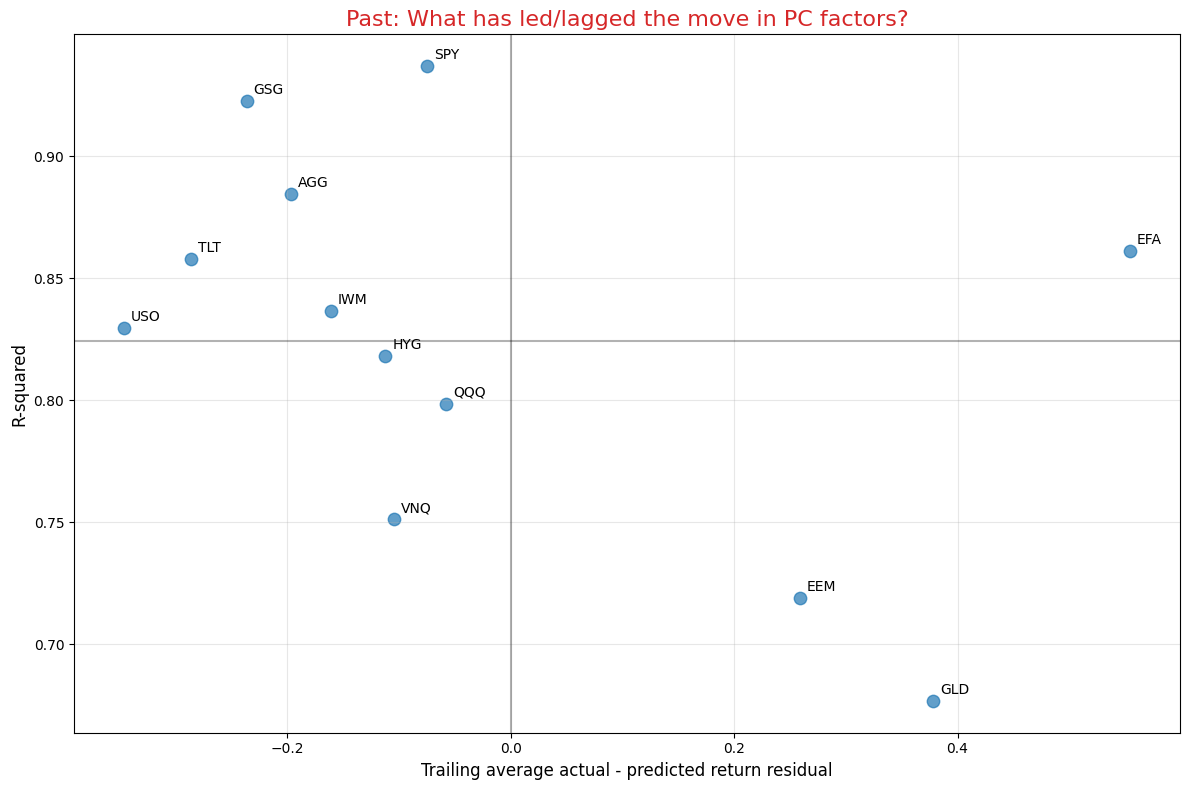

In [105]:
plt.figure(figsize=(12, 8))
plt.scatter(avg_residuals, r_squared_series, s=80, alpha=0.7)

# Add asset labels
for i, asset in enumerate(avg_residuals.index):
    plt.annotate(asset, (avg_residuals[i], r_squared_series[i]), 
                xytext=(5, 5), textcoords='offset points')

plt.axhline(y=np.mean(r_squared_series), color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Past: What has led/lagged the move in PC factors?', fontsize=16, color='#d62728')
plt.xlabel('Trailing average actual - predicted return residual', fontsize=12)
plt.ylabel('R-squared', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

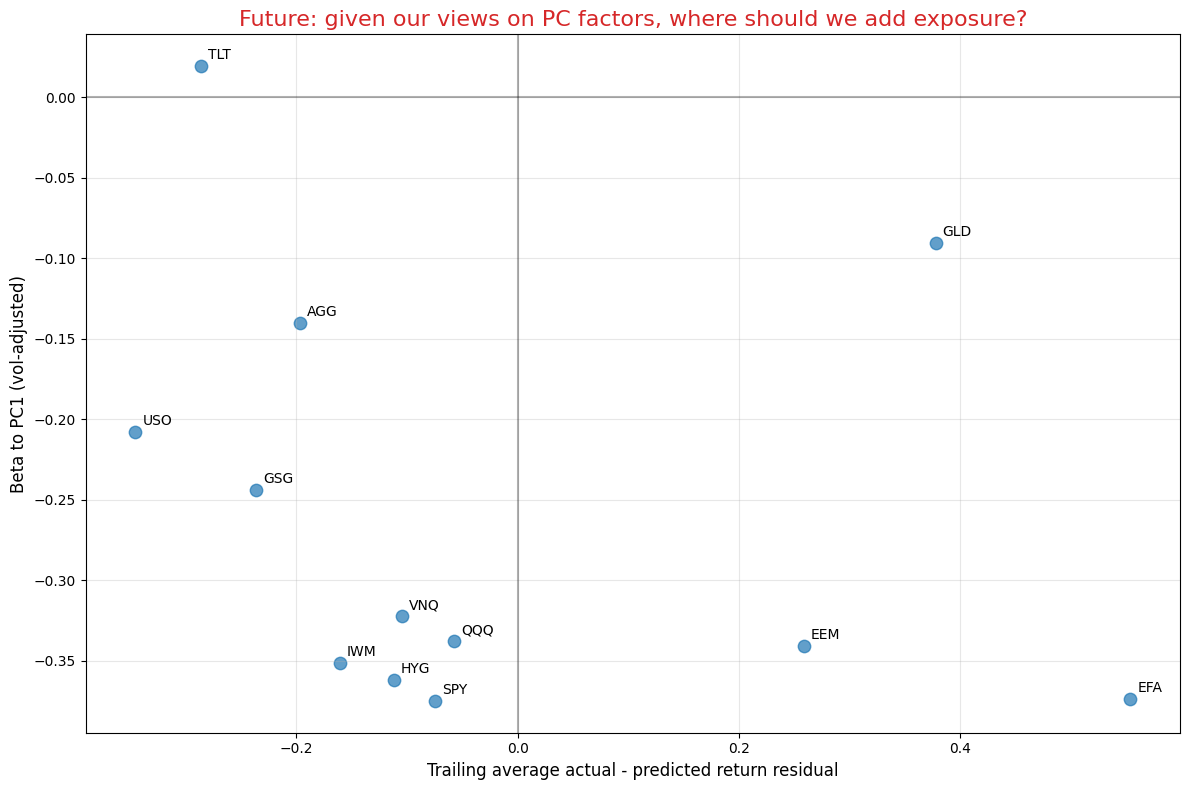

In [101]:
plt.figure(figsize=(12, 8))

# Create scatter plot
plt.scatter(avg_residuals, betas_series, s=80, alpha=0.7)

# Add asset labels
for i, asset in enumerate(avg_residuals.index):
    plt.annotate(asset, (avg_residuals[i], betas_series[i]), 
                xytext=(5, 5), textcoords='offset points')

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Future: given our views on PC factors, where should we add exposure?', 
          fontsize=16, color='#d62728')
plt.xlabel('Trailing average actual - predicted return residual', fontsize=12)
plt.ylabel('Beta to PC1 (vol-adjusted)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [107]:
std_errors = residuals_df.std() / np.sqrt(len(residuals_df))
t_stats = avg_residuals / std_errors
p_values = [2 * (1 - stats.t.cdf(abs(t), len(residuals_df) - 1)) for t in t_stats]

In [108]:
results_summary = pd.DataFrame({
    'Avg Residual': avg_residuals,
    'Std Error': std_errors,
    't-stat': t_stats,
    'p-value': p_values,
    'R-squared': pd.Series(r_squared)
})

In [109]:
results_summary = results_summary.sort_values('Avg Residual', ascending=False)

Assets LEADING the broader cross-asset performance (positive residuals):

In [110]:
for asset in results_summary.head(3).index:
    p_val = results_summary.loc[asset, 'p-value']
    sig_marker = '*' if p_val < 0.1 else ''
    print(f"- {asset}: +{results_summary.loc[asset, 'Avg Residual']:.3f} std dev {sig_marker}")
    print(f"  (t-stat: {results_summary.loc[asset, 't-stat']:.2f}, p-value: {results_summary.loc[asset, 'p-value']:.3f})")


- EFA: +0.554 std dev 
  (t-stat: 2.06, p-value: 0.109)
- GLD: +0.378 std dev 
  (t-stat: 1.24, p-value: 0.282)
- EEM: +0.259 std dev 
  (t-stat: 1.97, p-value: 0.120)


Assets LAGGING the broader cross-asset performance (negative residuals)

In [111]:
for asset in results_summary.tail(3).index:
    p_val = results_summary.loc[asset, 'p-value']
    sig_marker = '*' if p_val < 0.1 else ''
    print(f"- {asset}: {results_summary.loc[asset, 'Avg Residual']:.3f} std dev {sig_marker}")
    print(f"  (t-stat: {results_summary.loc[asset, 't-stat']:.2f}, p-value: {results_summary.loc[asset, 'p-value']:.3f})")


- GSG: -0.236 std dev 
  (t-stat: -1.69, p-value: 0.166)
- TLT: -0.286 std dev 
  (t-stat: -1.21, p-value: 0.293)
- USO: -0.346 std dev 
  (t-stat: -1.79, p-value: 0.148)
